In [1]:
import pandas as pd
import numpy as np
import replicaEVSE.load_curve as sim
import replicaEVSE.datautils as simdu
import matplotlib.pyplot as plt
import os
import joblib
from tqdm import tqdm
from glob import glob
import dask.dataframe as dd
import datetime as dt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

datadir = '../../data/'

 1) read in the loads and charges
 2) compute the peak load
 3) compute the fraction of charging events as a function of charger type

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=-1)  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default

In [3]:
seg_list = ['Personal Sedan',
 'Personal Crossover',
 'Personal Truck/SUV',
 'Commercial Sedan',
 'Commercial Crossover',
 'Commercial Truck/SUV']

# read in the loads and charges

In [4]:
charge_files = glob(datadir + 'loads_charges/charges_2*_2023-06-05.parquet')
charges_list = []
for cfile in charge_files:
    charges = dd.read_parquet(cfile)
    charges_list.append(charges)
charges = dd.concat(charges_list)

loads_files = glob(datadir + 'loads_charges/loads_2*_2023-06-05.parquet')
loads_list = []
for lfile in loads_files:
    loads = dd.read_parquet(lfile)
    loads_list.append(loads)
loads = dd.concat(loads_list)


In [6]:
reftime = ref_time=dt.datetime(2023, 1, 1, 0, 0)
loads["hour"] = (loads["window_end_time"]+ref_time).dt.hour

### Note: next time this these will output the weekday but for now we have to 
get the weekday by matching to the trips table via activity_id

In [7]:
trips = dd.read_parquet(datadir + 'wa_pop_and_trips_sorted.parquet')
trips = trips[trips['weekday'] == 'thursday']

In [8]:
charges = charges[charges['charger_power_kW'] > 0]

In [10]:
loadsmall = loads[['charge_id', 'hour', 'load_kW']]
loadscharges = loadsmall.merge(charges, on='charge_id', how='left')

In [11]:
loadscharges = loadscharges.drop(columns=['work_frac', 'multiunit_frac'])
loadscharges.columns

Index(['charge_id', 'hour', 'load_kW', 'person_id', 'charge_type',
       'activity_id', 'simulation_id', 'charger_power_kW',
       'charge_energy_used_kWh', 'charge_opportunity_remaining_kWh', 'year',
       'segment'],
      dtype='object')

In [12]:
tripsmall = trips[['activity_id', 'weekday']]

dask.dataframe.core.DataFrame

In [13]:
all = dd.merge(tripsmall, loadscharges, how='right')

In [14]:
all.columns

Index(['activity_id', 'weekday', 'charge_id', 'hour', 'load_kW', 'person_id',
       'charge_type', 'simulation_id', 'charger_power_kW',
       'charge_energy_used_kWh', 'charge_opportunity_remaining_kWh', 'year',
       'segment'],
      dtype='object')

### Find the max load per year

In [15]:
max_load = all.groupby(['year'])['load_kW'].max().compute()

In [13]:
# charges[charges['charger_power_kW']> 0]

charges['location'] = charges.charge_type.copy()
keep_values = ['single_family_home', 'multi_family_home', 'public']
home_values = ['public', 'work']

# Set values not in the keep list to 'work'
charges['location'] = charges['location'].where(charges['location'].isin(keep_values), 'work')
charges['location'] = charges['location'].where(charges['location'].isin(home_values), 'home')
charges['location'].unique()


array(['public', 'home', 'work'], dtype=object)

location
public                0.614633
single_family_home    0.340313
work                  0.026444
multi_family_home     0.018611
Name: count, dtype: float64

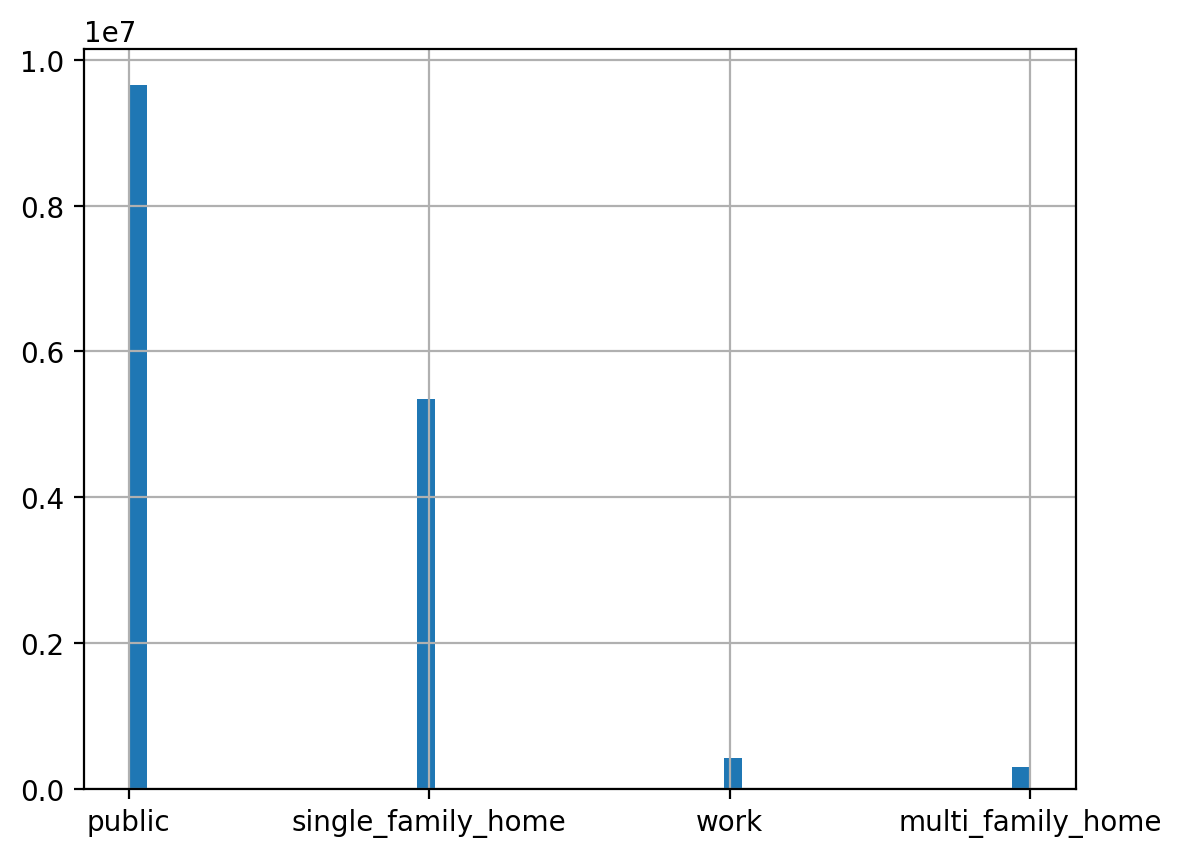

In [16]:
charges['location'] = charges.charge_type.copy()
keep_values = ['single_family_home', 'multi_family_home', 'public']
home_values = ['public', 'work']

# Set values not in the keep list to 'work'
charges['location'] = charges['location'].where(charges['location'].isin(keep_values), 'work')

charges[charges['charger_power_kW'] > 0]['location'].hist(bins=50)
charges[charges['charger_power_kW'] > 0]['location'].value_counts()/len(charges[charges['charger_power_kW'] > 0])

In [ ]:
def load_frac_by_loc(df, day='thursday', hour=19):
    df_thu = df.loc[(df.weekday == day)& (df['hour'] == hour)].copy()
    df_peak_load = df_thu.groupby(by=['location']).sum()
    total_load = df_peak_load.load_kW.sum()
    df_peak_load['load_frac_by_loc'] = df_peak_load.load_kW/total_load
    df_peak_load[['location', 'load_frac_by_loc']]
    print("peak load: ", total_load)
    return df_peak_load[['location', 'load_frac_by_loc']]

load_frac_by_loc(loads, day='thursday', hour=19)